# Dogs vs. Cats

In [1]:
# Выводим доступные девайсы для tensorflow

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13215472754886473370
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7608281457875728628
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12140269443385318682
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3519807488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9583466452990834821
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# Тест на доступ к GPU

In [4]:
#confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

# confirm PyTorch sees the GPU
#from torch import cuda
#assert cuda.is_available()
#assert cuda.device_count() > 0
#print(cuda.get_device_name(cuda.current_device()))

Using TensorFlow backend.


In [5]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [6]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

## Функции загрузки данных

In [7]:
import re
from random import shuffle
from glob import glob

train_files = glob('/home/pavel/HomeWork/train/*.jpg')
test_files = glob('/home/pavel/HomeWork/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

def is_dog(path):
    return re.match('.*dog\.\d', path) is not None

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)
            
            

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

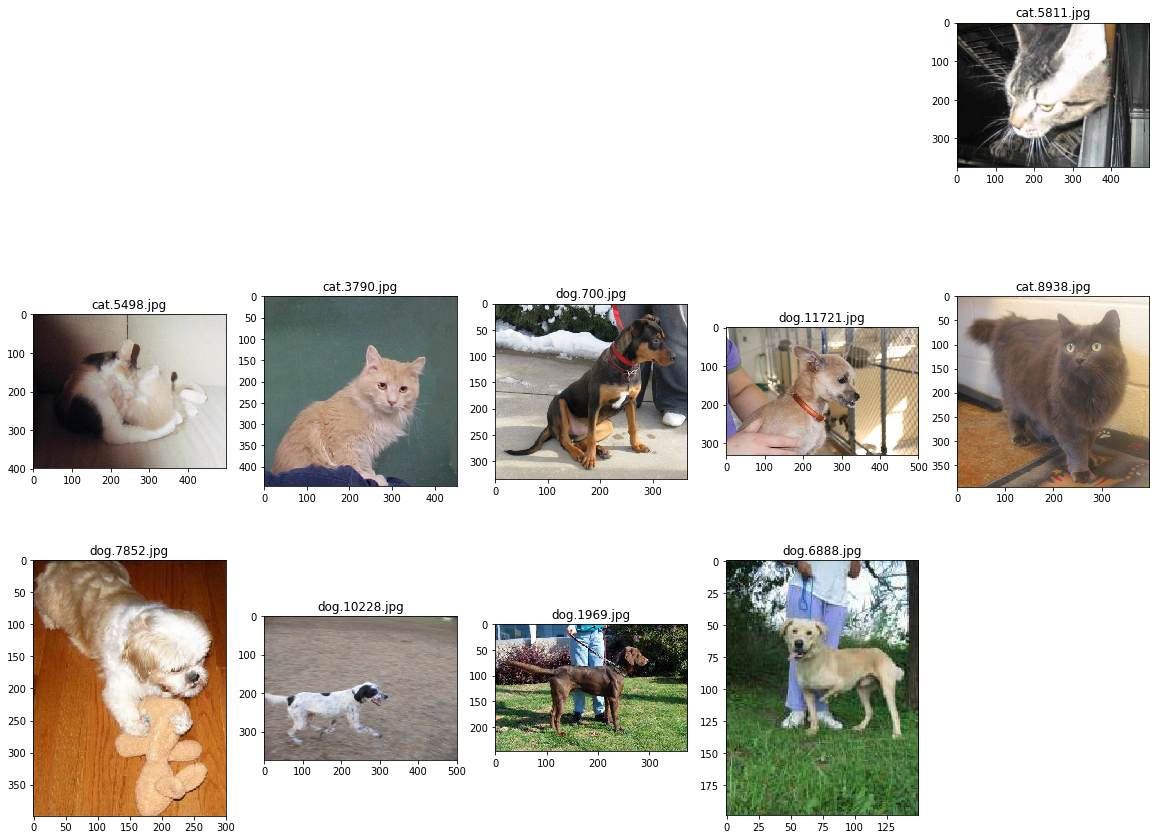

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

## Загружаем предобученную модель

In [9]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [10]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [11]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Добавляем полносвязный слой

In [12]:
from keras.layers.normalization import BatchNormalization 

#### Модель не сходилась при заданных параметрах в ноутбуке. Добавим еще 3 полносвязных слоя, слой с batch нормализацией и изменим регуляризацию с l1 на l2. 

In [30]:
x = base_model.layers[-5].output
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization(axis=1)(x)
x = keras.layers.Dense(64, 
                activation='relu')(x)
x = keras.layers.Dense(64, 
                activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(16, 
                activation='relu')(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l2(1e-7)
                      )(x)
model = Model(inputs=base_model.input, outputs=x)

## Выводим архитектуру модели

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Компилируем модель и запускаем обучение

In [32]:
# Изменим оптимизатор на RMSPROP
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [34]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=30,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/30
10/10 [==============================] - 4s 412ms/step - loss: 0.3415 - acc: 0.8781 - val_loss: 0.1061 - val_acc: 0.9700
Epoch 2/30
10/10 [==============================] - 4s 395ms/step - loss: 0.4536 - acc: 0.8469 - val_loss: 0.1126 - val_acc: 0.9500
Epoch 3/30
10/10 [==============================] - 4s 395ms/step - loss: 0.4851 - acc: 0.8781 - val_loss: 0.1163 - val_acc: 0.9700
Epoch 4/30
10/10 [==============================] - 4s 394ms/step - loss: 0.3665 - acc: 0.8812 - val_loss: 0.0927 - val_acc: 0.9600
Epoch 5/30
10/10 [==============================] - 4s 404ms/step - loss: 0.3946 - acc: 0.8875 - val_loss: 0.1426 - val_acc: 0.9600
Epoch 6/30
10/10 [==============================] - 4s 401ms/step - loss: 0.3856 - acc: 0.8875 - val_loss: 0.1699 - val_acc: 0.9700
Epoch 7/30
10/10 [==============================] - 4s 398ms/step - loss: 0.4169 - acc: 0.8969 - val_loss: 0.1612 - val_acc: 0.9600
Epoch 8/30
10/10 [==============================] - 4s 394ms/step - loss: 0.

In [ ]:
### Модель сошлась за 60 эпох (обучение запускал 2 раза по 30 эпох). Получено нужное качество loss и accuracy

In [ ]:
#model.save('cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [35]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

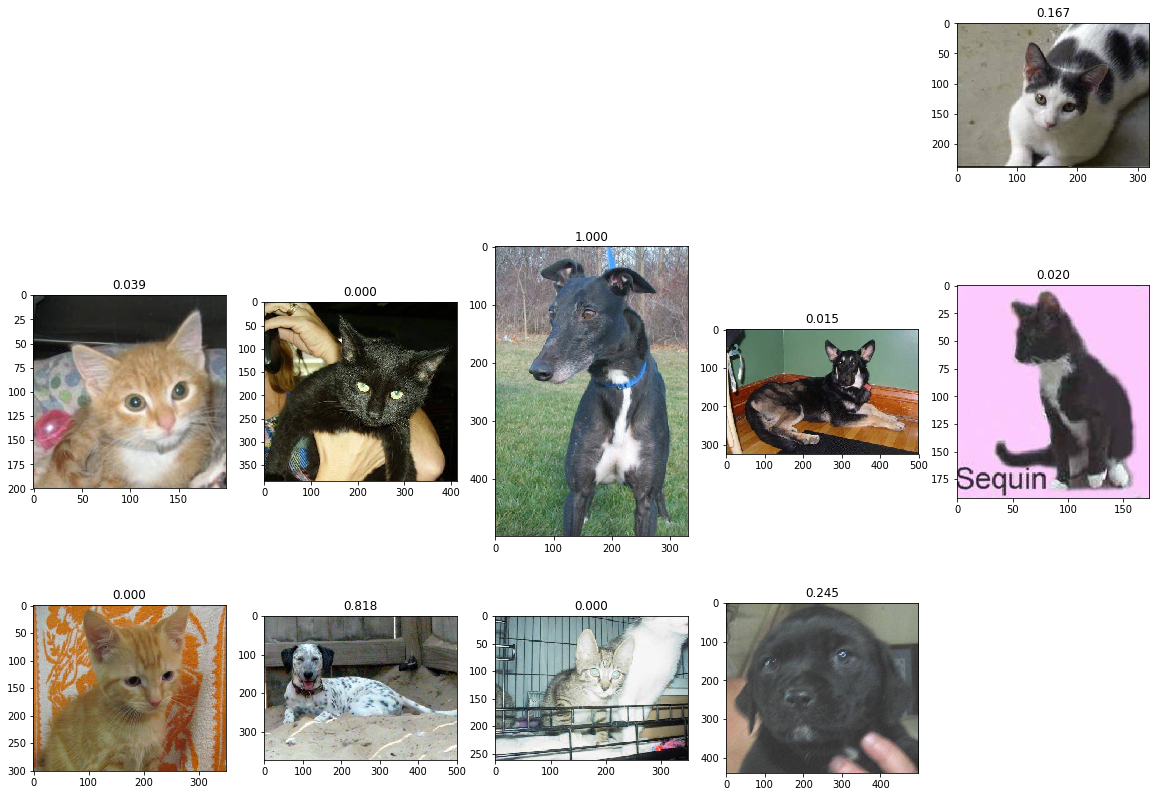

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [37]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

## На kaggle LogLoss = 0.20662

<img src="submit-cats-dogs.png" style="max-width: 680px; display: inline" />